# Отток клиентов

## Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Инструкция по выполнению проекта**
1. Загрузите и подготовьте данные. Поясните порядок действий.
1. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
1. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
1. Проведите финальное тестирование.

**Описание данных**

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»).

**Признаки**

1. RowNumber — индекс строки в данных
1. CustomerId — уникальный идентификатор клиента
1. Surname — фамилия
1. CreditScore — кредитный рейтинг
1. Geography — страна проживания
1. Gender — пол
1. Age — возраст
1. Tenure — количество недвижимости у клиента
1. Balance — баланс на счёте
1. NumOfProducts — количество продуктов банка, используемых клиентом
1. HasCrCard — наличие кредитной карты
1. IsActiveMember — активность клиента
1. EstimatedSalary — предполагаемая зарплата

**Целевой признак**

1. Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 21

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


In [3]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


* Удалим явно лишний столбец: `RowNumber` 
* Такжу удалим столбец `Surname`, так как врядли имя может влияеть на вероятность ухода из банка.
* Проверим столбец `CustomerId` на уникальность, если он уникальный, объявим его индеком

In [4]:
data = data.drop(columns=['RowNumber', 'Surname'])
data['CustomerId'].nunique() == data.shape[0]

True

In [5]:
data = data.set_index('CustomerId')
data.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


Видим что есть пропуски в столбце `Tenure`, заполним медианой

In [6]:
data.loc[data['Tenure'].isna(), 'Tenure'] = data['Tenure'].median()
data.isna().sum().sum()

0

In [7]:
data['Tenure'].value_counts()

5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: Tenure, dtype: int64

Разделим данные на признаки `X` и целевую переменную `y`

In [8]:
X = data.drop(columns=['Exited'])
y = data['Exited']

# 2. Исследование задачи

Выделим категориальные и количественные признаки

In [9]:
cat_feat = ['Geography', 'Gender']
num_feat = X.columns.drop(cat_feat).to_list()

Для категориальных признаков применим OHE

In [10]:
X = pd.get_dummies(X, columns=cat_feat, drop_first=True)
print(X.shape)
X.head(1)

(10000, 11)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,,
15634602,619,42,2.0,0.0,1,1,1,101348.88,0,0,0


Разобьем данные на train и test, сохранив баланс классов

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

Проверим дисбаланс целевого класса

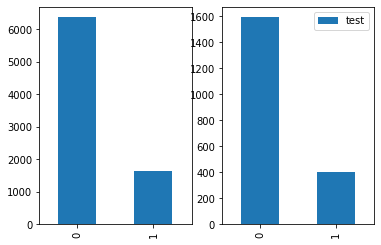

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2)
y_train.value_counts().plot(kind='bar', ax=ax1, label='train')
y_test.value_counts().plot(kind='bar', ax=ax2, label='test')
plt.legend()

## 2.1 Выбор модели

Будем использовать логистическую регрессию и случайный лес.

Для каждого алгоритма подберем лучшие гиперпарамерты поиском по сетке по метрике f1.

In [13]:
cv = StratifiedKFold(n_splits=5, random_state=SEED)

In [14]:
def best_model (model, params, X, y, cv, seed=SEED):
    '''
    Фунция для поиска оптимальных параметров модели
    Возвращает лучшие результаты кросс валидации
    '''
    grid = GridSearchCV(model, param_grid=params, cv=cv, scoring='f1')
    grid.fit(X, y)
    best_res = pd.DataFrame(grid.cv_results_).query('rank_test_score==1').reset_index().iloc[0, :]    
    return best_res

In [15]:
models = []
params = []

rf = RandomForestClassifier(random_state=SEED)
params_rf = {'max_features': list(range(1, X.shape[1]+1)),
             'n_estimators': [100]
            }

models.append(rf)
params.append(params_rf)

logit = LogisticRegression(random_state=SEED, solver='liblinear')
params_logit = {'C': np.logspace(-2, 1, 10)}

models.append(logit)
params.append(params_logit)

In [18]:
import tqdm

In [20]:
cols = ['mean_fit_time', 'mean_test_score', 'std_test_score', 'params']
d = []

for m, p in tqdm.tqdm(zip(models, params),total = len(params)):
    d.append(best_model(m, p, X_train, y_train, cv)[cols])

res = pd.DataFrame(data=d, index=['Forest', 'Logit'], columns=cols)
res

100%|██████████| 2/2 [01:46<00:00, 70.43s/it]


,mean_fit_time,mean_test_score,std_test_score,params
Forest,1.703222,0.570875,0.014995,"{'max_features': 7, 'n_estimators': 100}"
Logit,0.162608,0.100302,0.007197,{'C': 0.01}


Как мы видим случайный лес показывает, лучшие результаты, остановимся на нем

Дополнительно проверим значение roc_auc

In [21]:
rf_params = res.loc['Forest', 'params']
rf = RandomForestClassifier(**rf_params, random_state=SEED)
cv_score = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc')
cv_score.mean(), cv_score.std()

(0.847050254740877, 0.006178376570518335)

# 3. Борьба с дисбалансом

Поробуем бороться с ним используя upsampling и downsampling

In [22]:
def upsampling(X, y, shuffled=True, seed=21):
    '''
    Add samples for balancing data
    :param X: features DataFrame 
    :param y: target Series
    :param shuffled: if True output DataFrames will be shuffled
    :param seed: seed for numpy.seed()
    :return: X_up, y_up two DataFrames with upsampled data
    '''
    np.random.seed(seed)
    y_min_value = y.value_counts().sort_values().index[0]
    y_max_value = y.value_counts().sort_values().index[1]
    min_class_cnt = y.value_counts().min()
    max_class_cnt = y.value_counts().max()
    
    coef = max_class_cnt / min_class_cnt - 1
    idx = np.random.randint(0,
                            min_class_cnt,
                            size=np.round(min_class_cnt*coef).astype(int))
    
    X_new = X[y==y_min_value].values[idx]
    y_new = y[y==y_min_value].values[idx]
    
    X_up = pd.concat([X]+[pd.DataFrame(data=X_new, index=idx, columns=X.columns)])
    y_up = pd.concat([y]+[pd.Series(data=y_new, index=idx)])
    
    if shuffled:
        return shuffle(X_up, y_up, random_state=seed)
    else:
        return X_up, y_up

((12740, 11), (12740,))

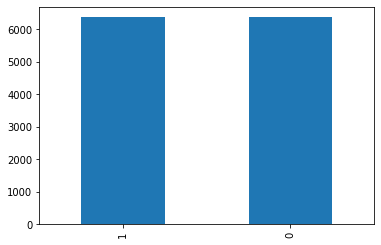

In [23]:
X_train_up, y_train_up = upsampling(X_train, y_train)

y_train_up.value_counts().plot(kind='bar')
X_train_up.shape, y_train_up.shape

Как видим upsampling помог выровнять дисбаланс классов

Дополнительно проверим не сломали ли мы распределение признаков на примере `CreditScore`

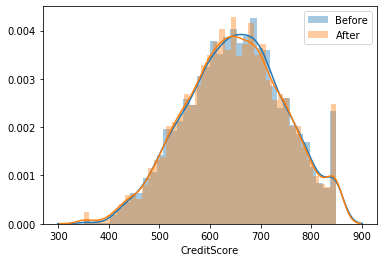

In [24]:
sns.distplot(X_train['CreditScore'], label='Before')
sns.distplot(X_train_up['CreditScore'], label="After")
plt.legend()

Как мы видим распределения практически идентичные, не забываем, что seaborn отмасштабировал графики по оси y.

Теперь реализуем downsampling, и выполним такие же проверки

In [25]:
def downsampling(X, y, shuffled=True, seed=21):
    '''
    Removind samples from biggest class for balancing data
    :param X: features DataFrame 
    :param y: target Series
    :param shuffled: if True output DataFrames will be shuffled
    :param seed: seed for numpy.seed()
    :return: X_down, y_down two DataFrames with downsampled data
    '''    
    np.random.seed(seed)
    y_min_value = y.value_counts().sort_values().index[0]
    y_max_value = y.value_counts().sort_values().index[1]
    min_class_cnt = y.value_counts().min()
    max_class_cnt = y.value_counts().max()
    
    idx = np.random.choice(max_class_cnt,
                           size=max_class_cnt - min_class_cnt,
                           replace=False)   
    print(idx.shape, max_class_cnt - min_class_cnt)
  
    X_down = X.drop(X[y==y_max_value].index[idx])
    y_down = y.drop(y[y==y_max_value].index[idx])
    
    if shuffled:
        return shuffle(X_down, y_down, random_state=seed)
    else:
        return X_down, y_down

(4740,) 4740


((3260, 11), (3260,))

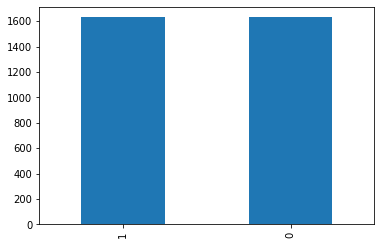

In [26]:
X_train_down, y_train_down = downsampling(X_train, y_train)

y_train_down.value_counts().plot(kind='bar')
X_train_down.shape, y_train_down.shape

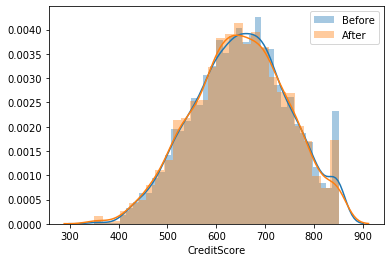

In [27]:
sns.distplot(X_train['CreditScore'], label='Before')
sns.distplot(X_train_down['CreditScore'], label="After")
plt.legend()

## 3.1 Проверка модели на новых данных

Проверим наш случайный лес на данных с upsample и downsample

In [28]:
results = {'roc_auc_mean': [],
           'roc_auc_std': [],
           'f1_mean': [],
           'f1_std': []}

XX = [X_train, X_train_up, X_train_down]
yy = [y_train, y_train_up, y_train_down]
index = ['source', 'up', 'down']

metrics = ['roc_auc', 'f1']

for x, y, i in zip(XX, yy, index):
    for m in metrics:
        print('Calculate '+ m + ' metrics for '+ i, end='...')
        cv_score = cross_val_score(rf, x, y, cv=cv, scoring=m)
        results[m + '_mean'].append(cv_score.mean())
        results[m + '_std'].append(cv_score.std())
        print('Done!')

pd.DataFrame(data=results, index=index)

Calculate roc_auc metrics for source...Done!
Calculate f1 metrics for source...Done!
Calculate roc_auc metrics for up...Done!
Calculate f1 metrics for up...Done!
Calculate roc_auc metrics for down...Done!
Calculate f1 metrics for down...Done!


,roc_auc_mean,roc_auc_std,f1_mean,f1_std
source,0.847050,0.006178,0.570875,0.014995
up,0.988952,0.002741,0.943855,0.001772
down,0.849078,0.011969,0.763101,0.012888


Мы видим существенный прирост качества на данных с upsampling

Это связано с переобучением модели, так как часть данных в результате перемешивания были и в обучающей и в валидационнй выборке на кросс валидации.

# 4. Тестирование модели

Доверимся тому что upsampling работает лучше.

Обучим лес и проверим его на тестовой выборке.

In [29]:
rf.fit(X_train_up, y_train_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [30]:
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred_proba)

(0.6202365308804205, 0.8564967124289159)

На тестовой выборке достигнуто необходимое значение метрики f1

roc_auc не сильно отличается от значение на валидации на исходной и downsampling выборках